In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
path = '/content/drive/MyDrive/Scan Documents/MRI_dataset'

In [17]:
datagen = ImageDataGenerator(rescale=1./255)


In [18]:
dataset = datagen.flow_from_directory(
    directory=path,  # Path to the main folder containing subfolders
    target_size=(224, 224),  # Resizing the input images (e.g., for ResNet-50)
    batch_size=32,
    class_mode='categorical')  # For multi-class classification

Found 2116 images belonging to 4 classes.


In [19]:
images, labels = next(dataset)

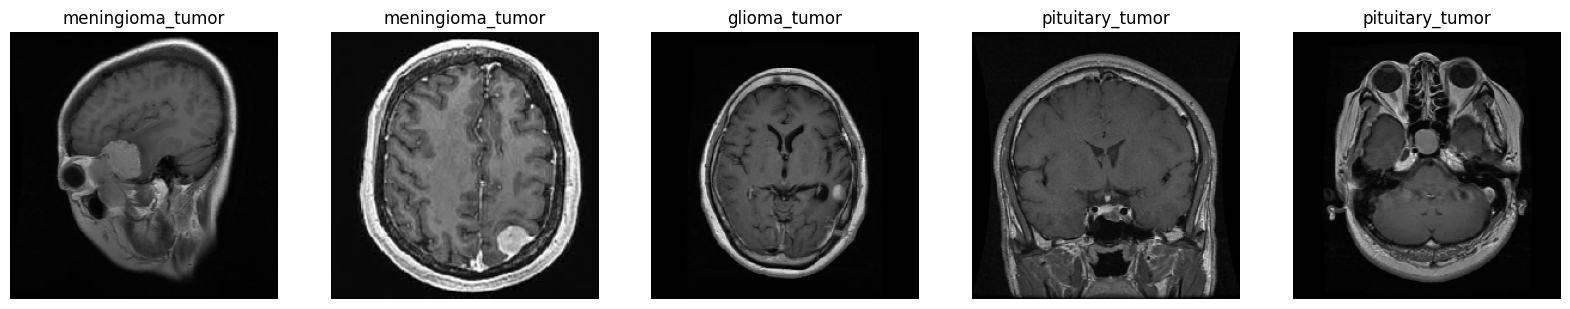

In [20]:
import matplotlib.pyplot as plt

# Number of images you want to display
num_images_to_show = 5

plt.figure(figsize=(20, 20))

for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(images[i])

    # Get the label index which is set to 1 (because of one-hot encoding)
    label_index = labels[i].argmax()

    # Get the label name using the class indices
    label_name = list(dataset.class_indices.keys())[list(dataset.class_indices.values()).index(label_index)]

    plt.title(label_name)
    plt.axis('off')

plt.show()


In [21]:
type(dataset)

keras.src.preprocessing.image.DirectoryIterator

In [22]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [23]:
# Create training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,  # Using 20% of the data for validation
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Since it's a multi-class problem
)

# Create validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 2116 files belonging to 4 classes.
Using 1693 files for training.
Found 2116 files belonging to 4 classes.
Using 423 files for validation.


In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load the ResNet50 model with weights pre-trained on ImageNet, exclude the top layers.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 [==============================] - 0s 0us/step


In [25]:
base_model.trainable = False

In [26]:
from tensorflow.keras.layers import Dropout

In [27]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [29]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 classes: glioma_tumor, meningioma_tumor, no_tumor, pituitary_tumor
])

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
epochs = 10
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/10
53/53 [==============================] - 198s 3s/step - loss: 1.2354 - accuracy: 0.4572 - val_loss: 0.7250 - val_accuracy: 0.6832
Epoch 2/10
53/53 [==============================] - 8s 134ms/step - loss: 0.7193 - accuracy: 0.7070 - val_loss: 0.5327 - val_accuracy: 0.8038
Epoch 3/10
53/53 [==============================] - 9s 145ms/step - loss: 0.5578 - accuracy: 0.7826 - val_loss: 0.4960 - val_accuracy: 0.8227
Epoch 4/10
53/53 [==============================] - 8s 149ms/step - loss: 0.4837 - accuracy: 0.8151 - val_loss: 0.5135 - val_accuracy: 0.7943
Epoch 5/10
53/53 [==============================] - 8s 137ms/step - loss: 0.4146 - accuracy: 0.8387 - val_loss: 0.5410 - val_accuracy: 0.8038
Epoch 6/10
53/53 [==============================] - 9s 150ms/step - loss: 0.3517 - accuracy: 0.8712 - val_loss: 0.5134 - val_accuracy: 0.8085
Epoch 7/10
53/53 [==============================] - 9s 153ms/step - loss: 0.3398 - accuracy: 0.8783 - val_loss: 0.5412 - val_accuracy: 0.8014
Epoch 8

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
true_classes = []
for images, labels in val_dataset:
    true_classes.extend(labels.numpy().argmax(axis=1))


In [46]:
# Get predictions
predictions = model.predict(val_dataset)
predicted_classes = predictions.argmax(axis=1)

14/14 [==============================] - 2s 100ms/step


In [47]:
from sklearn.metrics import classification_report

class_names = list(val_dataset.class_names)  # Names of the classes
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)


                  precision    recall  f1-score   support

    glioma_tumor       0.26      0.27      0.26       123
meningioma_tumor       0.28      0.24      0.26       120
        no_tumor       0.26      0.28      0.27        82
 pituitary_tumor       0.26      0.28      0.27        98

        accuracy                           0.26       423
       macro avg       0.27      0.27      0.27       423
    weighted avg       0.27      0.26      0.26       423



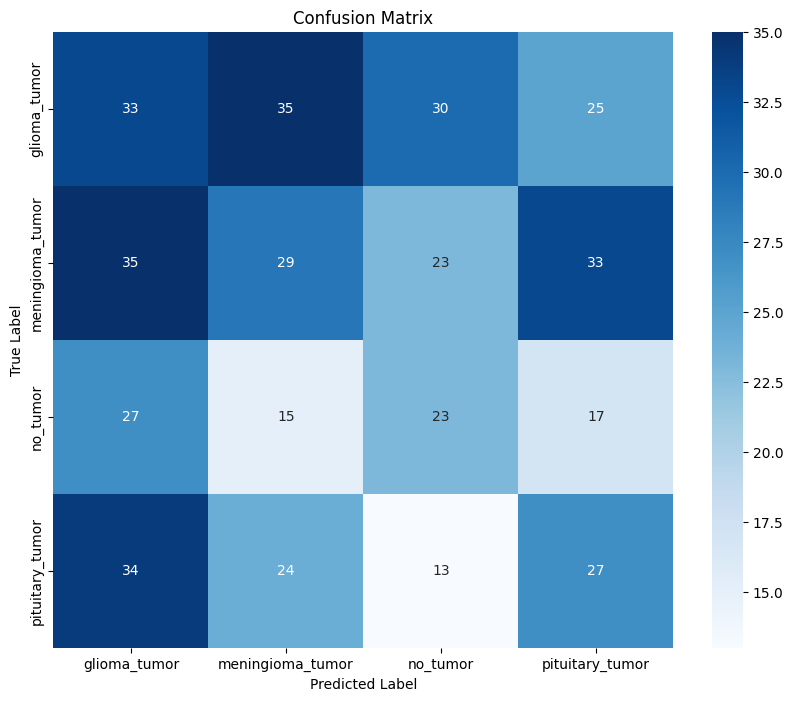

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                        

In [50]:
incorrect_predictions = (predicted_classes != true_classes).sum()
total_predictions = len(true_classes)
incorrect_ratio = incorrect_predictions / total_predictions

In [51]:
print(f"Incorrect Ratio: {incorrect_ratio:.2f}")

Incorrect Ratio: 0.74


In [52]:
incorrect_counts = {name: 0 for name in class_names}
total_counts = {name: 0 for name in class_names}

In [53]:
for true, pred in zip(true_classes, predicted_classes):
    true_name = class_names[true]
    total_counts[true_name] += 1

    if true != pred:
        incorrect_counts[true_name] += 1

In [54]:
incorrect_ratios = {name: incorrect_counts[name] / total_counts[name] for name in class_names}

In [55]:
for name, ratio in incorrect_ratios.items():
    print(f"Incorrect Ratio for {name}: {ratio:.2f}")

Incorrect Ratio for glioma_tumor: 0.73
Incorrect Ratio for meningioma_tumor: 0.76
Incorrect Ratio for no_tumor: 0.72
Incorrect Ratio for pituitary_tumor: 0.72
